In [3]:
#libraries
!pip install numpy matplotlib opencv-python-headless

#For emotion detection using DeepFace
!pip install deepface

#deep learning model used-RNN
!pip install tensorflow

#for downloading pdf
!pip install fpdf

#For image uploads in Google Colab
from google.colab import files
from google.colab.patches import cv2_imshow


  Preparing metadata (setup.py) ... done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40704 sha256=6e34b7cc6d021463fbbf8d3ee1b3f97fdffd8150962de4e2140ab8a9dee4abc1
  Stored in directory: /root/.cache/pip/wheels/65/4f/66/bbda9866da446a72e206d6484cd97381cbc7859a7068541c36
Successfully built fpdf


📁 Please upload a video for emotion analysis:


Saving Gen AI project video.mp4 to Gen AI project video.mp4
📹 Processing video...
25-06-09 08:02:45 - facial_expression_model_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facial_expression_model_weights.h5
To: /root/.deepface/weights/facial_expression_model_weights.h5
100%|██████████| 5.98M/5.98M [00:00<00:00, 100MB/s]


Analysis complete.


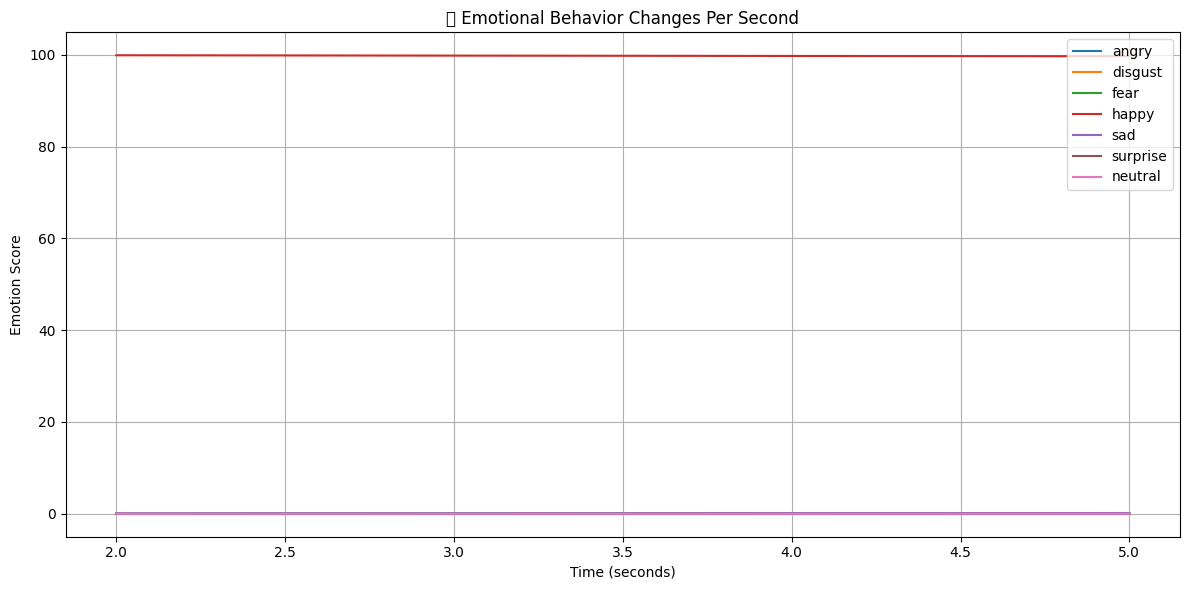


🔍 Behavioral Analysis Summary

🕒 Duration analyzed: 6 seconds
🏆 Dominant emotion: HAPPY

📊 Emotion Frequency:
   - HAPPY     : 2 times

🧠 Behavior Trend:
   → The subject exhibited positive behavior.


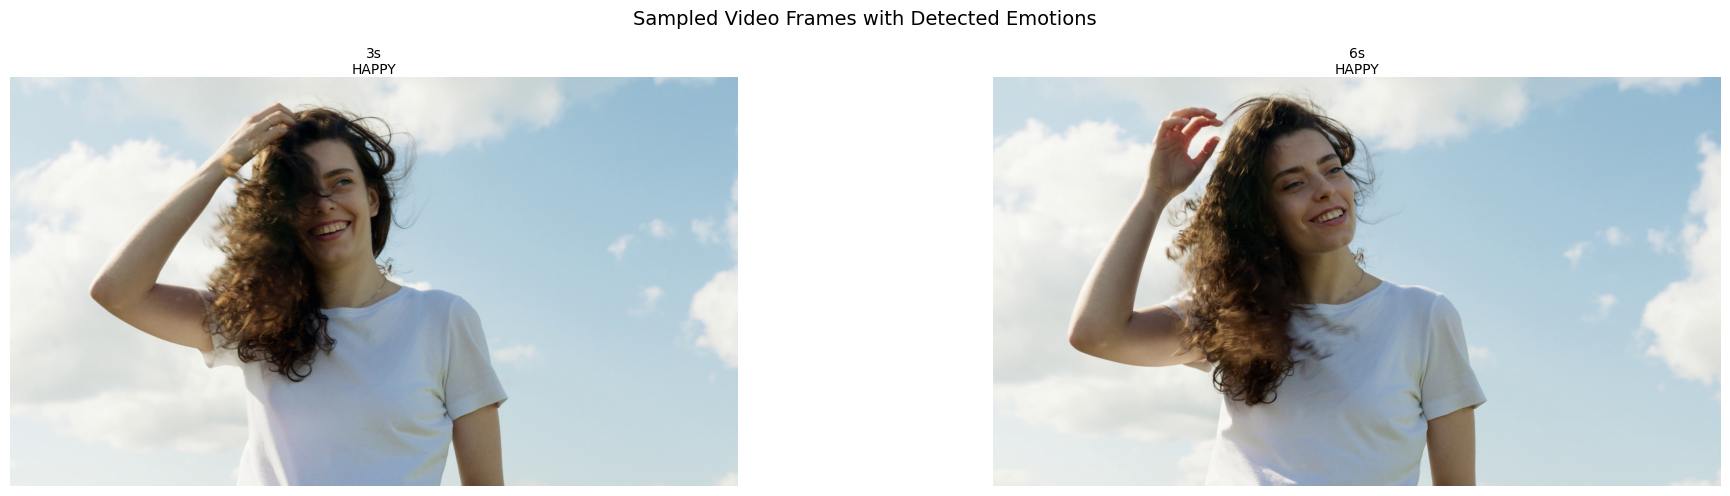

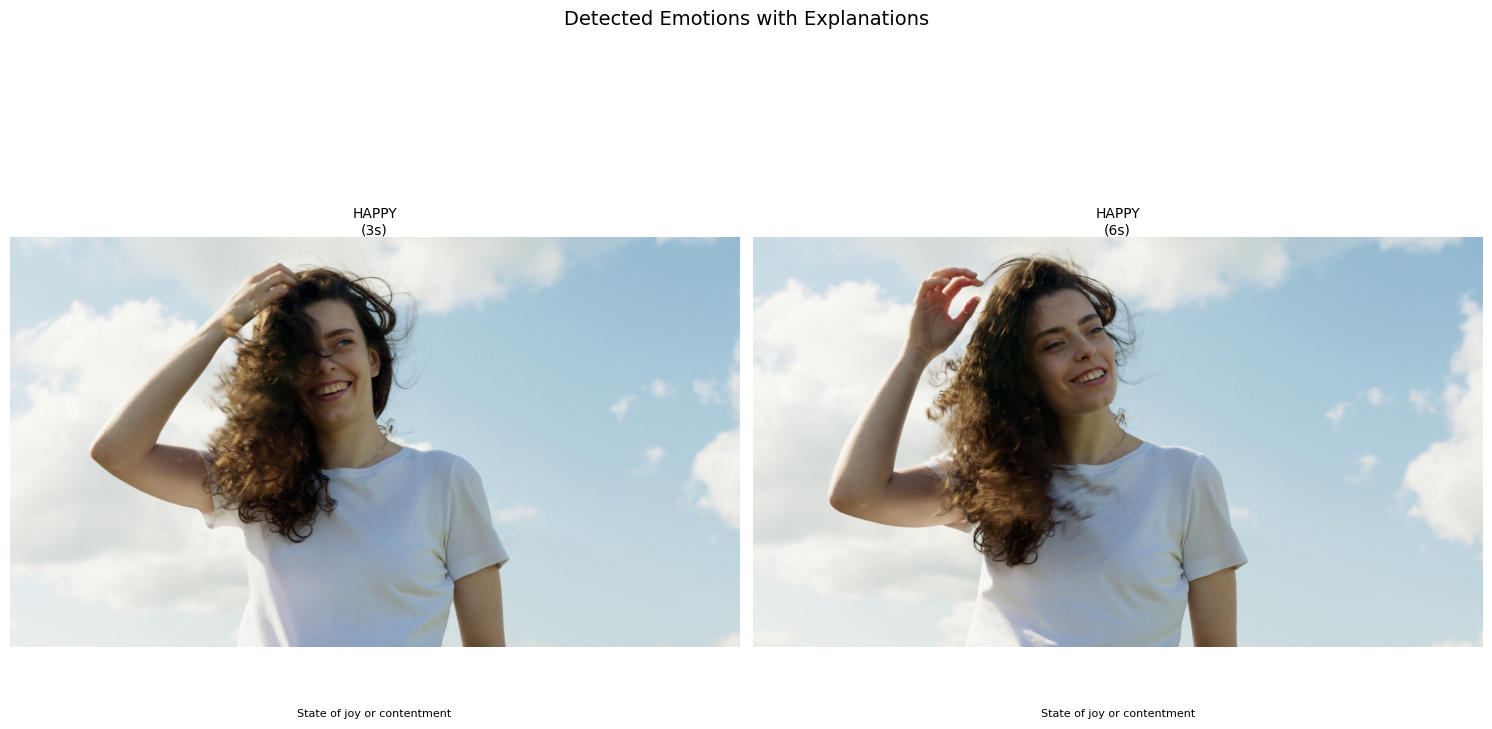


Not enough data for RNN analysis

 Report generated at: /content/emotion_report.pdf
Do you want to download the PDF report? (yes/no): yes


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The PDF report has been downloaded.


In [4]:
import cv2
import time
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from google.colab import files
from google.colab.patches import cv2_imshow
from deepface import DeepFace
import math
from fpdf import FPDF

# Emotion labels and their explanations
emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
emotion_explanations = {
    'angry': 'Strong displeasure or hostility',
    'disgust': 'Revulsion or disapproval',
    'fear': 'Belief of danger or threat',
    'happy': 'State of joy or contentment',
    'sad': 'Feeling of sorrow',
    'surprise': 'Response to unexpected event',
    'neutral': 'Lack of strong emotion'
}

# Storage for tracking
emotion_over_time = defaultdict(lambda: {label: 0 for label in emotion_labels})
emotion_dominance_tracker = []
captured_frames = []

# Label encoder
label_encoder = LabelEncoder()
label_encoder.fit(emotion_labels)

def choose_video_file():
    uploaded = files.upload()
    if uploaded:
        video_file = list(uploaded.keys())[0]
        file_path = os.path.join('/content/', video_file)
        return file_path
    return None

def analyze_emotion(frame):
    try:
        result = DeepFace.analyze(frame, actions=['emotion'], enforce_detection=False)
        dominant_emotion = result[0]['dominant_emotion']
        emotion_dominance_tracker.append(dominant_emotion)
        return result[0]['emotion']
    except Exception as e:
        print("Emotion detection failed:", e)
        return None

def process_video(file_path):
    cap = cv2.VideoCapture(file_path)
    if not cap.isOpened():
        print("Error: Unable to open video.")
        return

    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_count = 0

    print("\U0001F4F9 Processing video...")

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        current_second = int(frame_count / fps)
        frame_count += 1

        if frame_count % (fps * 3) == 0:  # sample every 3 seconds
            captured_frames.append(frame.copy())
            emotion_scores = analyze_emotion(frame)
            if emotion_scores:
                for emotion, score in emotion_scores.items():
                    emotion_over_time[current_second][emotion] = score

        if frame_count % (fps * 10) == 0:
            print(f"⏱️ Processed {current_second} seconds")

    cap.release()
    cv2.destroyAllWindows()
    print("Analysis complete.")
    plot_emotion_graph()
    generate_summary()
    display_captured_frames_grid()
    display_emotion_collage()
    rnn_emotion_sequence_analysis()
    generate_pdf_report()

def plot_emotion_graph():
    timestamps = sorted(emotion_over_time.keys())
    plt.figure(figsize=(12, 6))
    for emotion in emotion_labels:
        scores = [emotion_over_time[t][emotion] for t in timestamps]
        plt.plot(timestamps, scores, label=emotion)

    plt.title("\U0001F4C8 Emotional Behavior Changes Per Second")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Emotion Score")
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def display_captured_frames_grid():
    if not captured_frames:
        return

    num_images = len(captured_frames)
    cols = min(8, num_images)
    rows = math.ceil(num_images / cols)

    plt.figure(figsize=(20, 5 * rows))
    for i, (img, emotion) in enumerate(zip(captured_frames, emotion_dominance_tracker)):
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.title(f"{i * 3 + 3}s\n{emotion.upper()}", fontsize=10, pad=2)

    plt.suptitle("Sampled Video Frames with Detected Emotions", fontsize=14)
    plt.tight_layout(pad=1.0)
    plt.show()

def display_emotion_collage():
    if not captured_frames:
        return

    plt.figure(figsize=(15, 8))
    cols = min(4, len(captured_frames))
    rows = math.ceil(len(captured_frames) / cols)

    for i, (frame, emotion) in enumerate(zip(captured_frames, emotion_dominance_tracker)):
        img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        explanation = emotion_explanations.get(emotion, "No explanation available.")

        plt.subplot(rows, cols, i + 1)
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.title(f"{emotion.upper()}\n({i*3+3}s)", fontsize=10, pad=2)

        plt.text(0.5, -0.15, explanation,
                horizontalalignment='center',
                verticalalignment='top',
                transform=plt.gca().transAxes,
                fontsize=8,
                wrap=True)

    plt.suptitle("Detected Emotions with Explanations", fontsize=14, y=1.02)
    plt.tight_layout(pad=1.0)
    plt.show()

def generate_summary():
    print("\n" + "="*50)
    print("\U0001F50D Behavioral Analysis Summary")
    print("="*50)

    total_time = max(emotion_over_time.keys()) + 1
    dominant_counter = Counter(emotion_dominance_tracker)
    dominant_emotion = dominant_counter.most_common(1)[0][0]

    print(f"\n\U0001F552 Duration analyzed: {total_time} seconds")
    print(f"\U0001F3C6 Dominant emotion: {dominant_emotion.upper()}")

    print("\n\U0001F4CA Emotion Frequency:")
    for emotion, count in dominant_counter.items():
        print(f"   - {emotion.upper():<10}: {count} times")

    print("\n\U0001F9E0 Behavior Trend:")
    if dominant_emotion == "happy":
        print("   → The subject exhibited positive behavior.")
    elif dominant_emotion == "sad":
        print("   → The subject showed signs of sadness.")
    elif dominant_emotion == "angry":
        print("   → The subject appeared agitated or angry.")
    elif dominant_emotion == "neutral":
        print("   → The subject remained mostly neutral.")
    else:
        print("   → Emotional state was varied without dominance.")

    print("="*50)

def rnn_emotion_sequence_analysis():
    if len(emotion_dominance_tracker) < 3:
        print("\nNot enough data for RNN analysis")
        return

    print("\n\U0001F4CA RNN Behavior Modeling")
    encoded = label_encoder.transform(emotion_dominance_tracker)
    sequences = [encoded[:i+1] for i in range(len(encoded)) if len(encoded[:i+1]) > 1]
    padded = pad_sequences(sequences, padding='pre', maxlen=10)

    model = Sequential()
    model.add(Embedding(input_dim=len(emotion_labels), output_dim=10, input_length=10))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dense(len(emotion_labels), activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    targets = encoded[1:]
    padded = padded[:len(targets)]

    model.fit(padded, targets, epochs=10, verbose=0)

    preds = model.predict(padded)
    pred_labels = label_encoder.inverse_transform(np.argmax(preds, axis=1))

    print(f"\n\U0001F4C8 RNN Predicted Emotion Trend:")
    print(" → " + " ➜ ".join(pred_labels[-10:]))

def generate_pdf_report():
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=12)
    pdf.cell(200, 10, txt="Emotion Analysis Report", ln=True, align="C")

    total_time = max(emotion_over_time.keys()) + 1
    dominant_counter = Counter(emotion_dominance_tracker)
    dominant_emotion = dominant_counter.most_common(1)[0][0]

    pdf.ln(10)
    pdf.cell(200, 10, txt=f"Total Duration Analyzed: {total_time} seconds", ln=True)
    pdf.cell(200, 10, txt=f"Dominant Emotion: {dominant_emotion.upper()}", ln=True)
    pdf.ln(10)

    pdf.cell(200, 10, txt="Emotion Frequencies:", ln=True)
    for emotion, count in dominant_counter.items():
        pdf.cell(200, 10, txt=f" - {emotion.upper()}: {count}", ln=True)

    file_path = "/content/emotion_report.pdf"
    pdf.output(file_path)
    print(f"\n Report generated at: {file_path}")

    user_input = input("Do you want to download the PDF report? (yes/no): ").strip().lower()
    if user_input == 'yes':
        files.download(file_path)
        print("The PDF report has been downloaded.")
    else:
        print("The PDF report is available but not downloaded.")

# Main Execution
print("\U0001F4C1 Please upload a video for emotion analysis:")
video_file = choose_video_file()
if video_file:
    process_video(video_file)
else:
    print("No file selected.")